# 1. Data preparation

In [2]:
import sys
import os

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Add submodules needed for data preparation
sys.path.insert(0, os.path.abspath("./poligrain/src"))
sys.path.insert(0, os.path.abspath("./pycomlink"))

import pycomlink as pycml
import poligrain as plg

## Download OpenMRG dataset 

In [3]:
# Use gdown to iterate through folder, we will replace this later
!pip install --quiet gdown

In [13]:
# Individual data files, {where to store: download_id}
file_ids = {
    './data/cml/cml.nc': '1MqH4Dzb7Ff-inpWNWQyOFHBWDCO5uKfc',
    './data/radar/radar.nc': '168zv5u9Qb4eZ5W62CuKmHrWyTSS3Z9U2',
    './data/gauges/city_gauge.nc': '1190fQu3ie_93e7iJpZEC-p92h9y8XtOW',     
    './data/gauges/smhi_gauge.nc': '1j7MdStiY1xdWeJrrsEXgHCqMoT9Qy67z',    
    './data/era5/era5.nc': '1ryNLVox1me_5orrAaTHw8-nROkhpffw1',    
    './data/gpm_imerg/gpm_imerg_early.nc': '1rck6vKonptGsV9sPauRmzrAmtD1Xan_u',
    './data/gpm_imerg/gpm_imerg_final.nc': '1zOZD5wPezuVIXl-PaUFWvUrM_cn_O2Nq',    
    './data/seviri/seviri.nc': '1aeSovV7K-H5i0sHmpdqFYHsX0zgHmRXC',
    './data/netatmo/netatmo_pressure.nc': '1gq_wFdCOyF697teOEYGH8yg8mTgvvzOa',
    './data/netatmo/netatmo_temp.nc': '1AhFxkOxqpyNBOhLFHm4f7lpSA745imwI',
    './data/netatmo/netatmo_humidity.nc': '12fw2nO1f_BRDm3sLKJDfsIKRYl65RRLQ',
    './data/netatmo/netatmo_rain.nc': '1hjJq5sdHBDjNvw5oeLMXVjkdH-P36cpC',
    './data/netatmo/netatmo_raw.nc': '1Nc9pMi6zFJ7eN7kJGyJLoU_c7bWRrMWT',
}

for file_path, file_id in file_ids.items():
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    if not os.path.exists(file_path):
        print(f"Downloading {file_path} ...")
        !gdown {file_id} -O {file_path}
    else:
        print(f"skip {file_path}")

skip ./data/cml/cml.nc
skip ./data/radar/radar.nc
Downloading...
From: https://drive.google.com/uc?id=1190fQu3ie_93e7iJpZEC-p92h9y8XtOW
To: /home/erlend/git/OpenMRG2/data/gauges/city_gauge.nc
100%|██████████████████████████████████████| 11.7M/11.7M [00:00<00:00, 28.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1j7MdStiY1xdWeJrrsEXgHCqMoT9Qy67z
To: /home/erlend/git/OpenMRG2/data/gauges/smhi_gauge.nc
100%|████████████████████████████████████████| 152k/152k [00:00<00:00, 4.58MB/s]
skip ./data/era5/era5.nc
skip ./data/gpm_imerg/gpm_imerg_early.nc
skip ./data/gpm_imerg/gpm_imerg_final.nc
skip ./data/seviri/seviri.nc
skip ./data/netatmo/netatmo_pressure.nc
skip ./data/netatmo/netatmo_temp.nc
skip ./data/netatmo/netatmo_humidity.nc
skip ./data/netatmo/netatmo_rain.nc
skip ./data/netatmo/netatmo_raw.nc


## Process data

### Process radar data

In [17]:
# Load raw radar files
ds_rad = xr.open_dataset("./data/radar/radar.nc")

# Apply marsha- palmer to get rainfall rates
ds_rad["rainfall_radar"] = (10 ** (ds_rad.data / 10) / 200) ** (5 / 8)

# Flip along y axis to work in the grid intersection function
ds_rad["latitudes"] = (("y", "x"), np.flip(ds_rad.lat.data, axis=0))
ds_rad["rainfall_radar"] = (
    ("time", "y", "x"),
    np.flip(ds_rad.rainfall_radar.data, axis=1),
)

# Convert to 15min resolution
ds_rad_15min = ds_rad[['crs', 'lat', 'lon', 'rainfall_radar']].resample(time='15min', label='right', closed='right').mean()
ds_rad_15min.rainfall_radar.attrs["units"] = "15min rainfall rate [mm/h]"

# Save radar
ds_rad_15min.to_netcdf('data/radar/radar_15min.nc')

### Visualize radar data

In [18]:
# Display dataset
ds_rad_15min

<xarray.Dataset> Size: 126MB
Dimensions:         (time: 8832, y: 48, x: 37)
Coordinates:
  * time            (time) datetime64[ns] 71kB 2015-06-01T00:15:00 ... 2015-0...
  * y               (y) float64 384B -3.413e+06 -3.415e+06 ... -3.507e+06
  * x               (x) float64 296B -1.542e+05 -1.522e+05 ... -8.22e+04
    crs             int32 4B 1
    lat             (y, x) float32 7kB 58.04 58.04 58.04 ... 57.23 57.23 57.23
    lon             (y, x) float32 7kB 11.41 11.45 11.48 ... 12.59 12.62 12.66
Data variables:
    rainfall_radar  (time, y, x) float64 125MB nan nan nan ... 2.719 2.597 3.137
Attributes:
    source:       Swedish Meteorological and Hydrological Institute (SMHI), H...
    contact:      hydro.fou@smhi.se, remco.vandebeek@smhi.se
    title:        OpenMRG-Radar
    license:      https://creativecommons.org/licenses/by-sa/4.0
    version:      1.1
    doi:          https://doi.org/10.5281/zenodo.6673750
    proj_string:  +proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90
    comment:      Created by Remco van de Beek, Victor Näslund and Johan Thur...

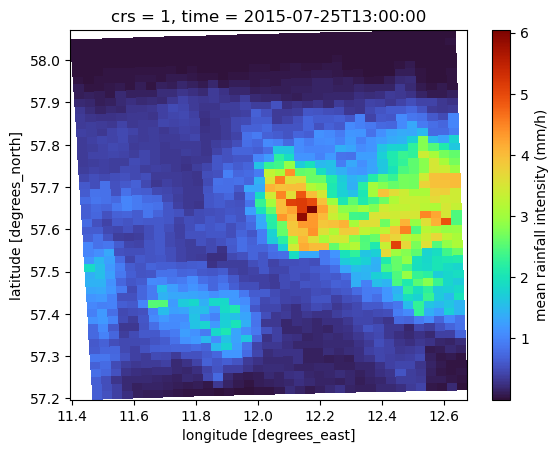

In [26]:
# Plot radar field
plg.plot_map.plot_plg(
    da_grid=ds_rad_15min.rainfall_radar.sel(time = '2015-07-25T13:00'),
    use_lon_lat=True,
    colorbar_label="mean rainfall intensity (mm/h)",
);

### Process CML data

In [7]:
# Load CML data, select sublink 0 and resample to 1 min resolution
ds_cmls = xr.open_dataset("./data/cml/cml.nc").isel(sublink_id = 0).load().resample(time="1min").first(skipna=True)

# Calculate total loss
ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl

# Interpolate na
ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# Flag cmls with strong diurnal fluctuations
qc_diurnalcycle = (ds_cmls.tl.rolling(time=60 * 5, center=True).std() > 2).mean(dim="time") > 0.1

# Flag cmls with very noisy periods
qc_noisyperiods = (ds_cmls.tl.rolling(time=60, center=True).std() > 0.8).mean(dim="time") > 0.20

# Drop flagged CMLs
ds_cmls.where(qc_diurnalcycle, drop=True);
ds_cmls.where(qc_noisyperiods, drop=True);

In [8]:
# CML wet/dry detection using radar
da_intersect_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cmls.site_0_lon.values,
    y1_line=ds_cmls.site_0_lat.values,
    x2_line=ds_cmls.site_1_lon.values,
    y2_line=ds_cmls.site_1_lat.values,
    cml_id=ds_cmls.cml_id.values,
    x_grid=ds_rad.lon.values,
    y_grid=ds_rad.lat.values,
    grid_point_location='center',
)

da_radar_along_cmls = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.rainfall_radar, # In mm/h
    intersect_weights=da_intersect_weights,
).resample(time = '1min').bfill()

# Set wet periods above threshold
ds_cmls['wet_radar']  = (da_radar_along_cmls > 0.01).rolling(time=5, center=True).max()

In [9]:
# CML wet/dry detection using CML tl
roll_std_dev = ds_cmls.tl.rolling(time=60, center=True).std()
threshold = 1.12 * roll_std_dev.quantile(0.8, dim="time")
ds_cmls["wet_cml"] = (roll_std_dev > threshold)

/home/erlend/miniforge3/envs/openmrg/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


In [10]:
# Estimate baseline
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet_cml.astype(bool)| ds_cmls.wet_radar.astype(bool), # wet period if radar or CML is wet
    n_average_last_dry=5,
)

ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)

# WAA using Pastorek with parameters that looks good 
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=6,
    zeta=0.7,  
    d=0.15,
)

# Calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0

# Derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,  # convert to km
    f_GHz=ds_cmls.frequency / 1000,  # convert to GHz
    pol=ds_cmls.polarization,
)

In [11]:
# Resample to 15 min resolution
ds_cmls_15min = ds_cmls.R.resample(time="15min", label='right', closed='right').mean(skipna=True).to_dataset()
ds_cmls_15min.R.attrs["units"] = "15min rainfall rate [mm/h]"

# Save CML
ds_cmls_15min.to_netcdf('data/cml/cml_15min.nc')

In [12]:
# Display dataset
ds_cmls_15min

<xarray.Dataset> Size: 26MB
Dimensions:       (cml_id: 364, time: 8833)
Coordinates:
  * cml_id        (cml_id) int64 3kB 10001 10002 10003 ... 10362 10363 10364
  * time          (time) datetime64[ns] 71kB 2015-06-01 ... 2015-09-01
    sublink_id    <U9 36B 'sublink_1'
    site_0_lat    (cml_id) float64 3kB 57.7 57.73 57.69 ... 57.65 57.66 57.71
    site_0_lon    (cml_id) float64 3kB 12.0 11.98 11.97 ... 12.12 12.03 12.01
    site_1_lat    (cml_id) float64 3kB 57.7 57.72 57.69 ... 57.66 57.63 57.71
    site_1_lon    (cml_id) float64 3kB 11.99 11.97 11.98 ... 12.14 11.97 11.98
    frequency     (cml_id) float64 3kB 2.821e+04 3.853e+04 ... 2.825e+04
    polarization  (cml_id) <U1 1kB 'v' 'v' 'v' 'v' 'v' ... 'v' 'v' 'v' 'v' 'v'
    length        (cml_id) float64 3kB 691.4 614.6 323.7 ... 4.806e+03 1.412e+03
    quantile      float64 8B 0.8
Data variables:
    R             (cml_id, time) float64 26MB 0.0 0.01244 ... 2.838 3.665

### Vizualize CML data

In [ ]:
# radar rainfall along one cml path
(ds_cml.radar_along_cml*60).sel(cml_id=10001).plot(label='radar along CML rainfall (mm/h)')
ds_cml.rsl.sel(cml_id=10001,sublink_id='sublink_1').plot(label='received signal level (dB)')
plt.legend()
plt.title('Radar rainfall and RSL along one cml path');

### Process rain gauge data

In [8]:
# Load city rain gauge data, unit is sum rainfall / minute
ds_gauges_city = xr.open_dataset('./data/gauges/city_gauge.nc').load()

# Resample city rain gauge data to 15min mm/h
ds_gauges_city = ds_gauges_city.resample(time="15min", label="right", closed="right").mean()*60

In [9]:
# Load SMHI data, unit is sum rainfall / 15min
ds_gauges_smhi = xr.open_dataset('./data/gauges/smhi_gauge.nc').load()

# Scale to mm/h
ds_gauges_smhi['rainfall_amount'] = ds_gauges_smhi.rainfall_amount*4


In [10]:
# Concat city and smhi data
ds_gauges_15min = xr.concat([ds_gauges_city, ds_gauges_smhi], dim="id")

# Rename variable
ds_gauges_15min = ds_gauges_15min.rename({"rainfall_amount": "R"})

# Save rain gauge data
ds_gauges_15min.to_netcdf('data/gauges/gauge_15min.nc')

In [11]:
ds_gauges_15min

<xarray.Dataset> Size: 850kB
Dimensions:       (time: 8832, id: 11)
Coordinates:
  * time          (time) datetime64[ns] 71kB 2015-06-01T00:15:00 ... 2015-09-01
  * id            (id) <U6 264B 'Jarn' 'Torp' 'Bergsj' ... 'Lbom' 'Askim' 'SMHI'
    lon           (id) float64 88B 11.94 12.04 12.07 11.79 ... 11.97 11.94 11.99
    lat           (id) float64 88B 57.65 57.72 57.75 57.71 ... 57.71 57.63 57.72
    location      (id) <U16 704B 'Järnbrottsmotet' ... 'Goeteburg A'
    type          (id) <U19 836B 'Weighing' 'Weighing' ... '15 min rainfall sum'
    quantization  (id) float64 88B 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.1
Data variables:
    R             (time, id) float64 777kB 3.6 3.6 4.0 2.0 ... 2.4 3.2 4.0 2.4

### Process NETATMO data

In [12]:
# Load NETATMO data
ds_netatmo_rain = xr.open_dataset('./data/netatmo/netatmo_rain.nc').load()

# Get elevation values (assume they are in order)
elev_values = ds_netatmo_rain['elevation'].values

# Assign elevation as a coordinate of id, removes erronous dimension
ds_netatmo_rain = ds_netatmo_rain.assign_coords(elevation=('id', elev_values))

# Rename coordiantes to comply with opensense standard
ds_netatmo_rain = ds_netatmo_rain.rename({
    'latitude':'lat', 
    'longitude':'lon',
    'rainfall': 'R',
})

# Resample rainfall data to mm/h per 15min
ds_netatmo_rain_15min = ds_netatmo_rain.resample(time="15min", label="right", closed="right").mean()*12

# Save netatmo rain gauge data
ds_netatmo_rain_15min.to_netcdf('data/netatmo/netatmo_rain_15min.nc')

In [15]:
ds_netatmo_rain_15min

<xarray.Dataset> Size: 2MB
Dimensions:    (id: 30, time: 8833)
Coordinates:
  * id         (id) <U2 240B '0' '1' '2' '3' '4' ... '25' '26' '27' '28' '29'
  * time       (time) datetime64[ns] 71kB 2015-06-01 ... 2015-09-01
    lat        (id) float64 240B 57.72 57.58 57.77 57.73 ... 57.67 57.58 57.69
    lon        (id) float64 240B 12.37 12.25 12.26 11.95 ... 11.87 12.07 12.11
    elevation  (id) float64 240B 119.0 73.0 21.0 4.0 7.0 ... 22.0 8.0 40.0 118.0
Data variables:
    R          (time, id) float64 2MB 3.636 2.424 5.46 ... 1.212 2.02 2.424
Attributes:
    title:                 NetAtmo data from Gothenburg for OpenMRG+
    file author:           Remco van de Beek
    institution:           Swedish Meteorological and Hydrologcial Institute
    date:                  2025-10-29 09:01:00
    source:                Netamo PWS
    history:               Data derived and reformated from original dataset ...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

### Process IMERG and ERA5 data

In [35]:
import pandas as pd

In [36]:
ds_gpm_imerg_early = xr.open_dataset("./data/gpm_imerg/gpm_imerg_early.nc")
ds_gpm_imerg_final = xr.open_dataset("./data/gpm_imerg/gpm_imerg_final.nc")
ds_era5 = xr.open_dataset("./data/era5/era5.nc")

In [37]:
ds_gpm_imerg_early = ds_gpm_imerg_early.assign_coords(
    time=np.array([np.datetime64(pd.Timestamp(t).strftime('%Y-%m-%dT%H:%M:%S')) for t in ds_gpm_imerg_early.time.values])
)

ds_gpm_imerg_final = ds_gpm_imerg_final.assign_coords(
    time=np.array([np.datetime64(pd.Timestamp(t).strftime('%Y-%m-%dT%H:%M:%S')) for t in ds_gpm_imerg_final.time.values])
 )